In [1]:
import numpy as np
from black_jack import BlackjackEnv
from tqdm import tqdm

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

In [2]:
def draw_wireframe(data):
    x = y = np.arange(0, 10)
    x, y = np.meshgrid(x, y)
    z = data[0][:][:]
    fig = plt.figure(figsize=(30, 4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.view_init(elev=35,azim=-80)
    ax.plot_wireframe(x, y, z, rstride=1, cstride=1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(elev=35,azim=-80)
    z = data[1][:][:]
    ax.plot_wireframe(x, y, z, rstride=1, cstride=1)

    plt.show()

In [3]:
env = BlackjackEnv()

### First-visit MC prediction, for estimating $V \approx v_\pi$

In a Blackjack game, there are three variables for the player to consider:
- Current sum of the cards, obviously only the range (12-21) should be considered, since if the sum is less or equal to 11, the player should always hit.
- The dealer's one showing card, which can be valued in the range of ace to 10 (numerically we can consider the ace as 1).
- Whether or not he holds a usable ace, binary-valued variable.

Thus we can use an array of shape (2, 10, 10) as our state-value function, for the convenience of random access.

NB: an incremental implementation is used for memory efficiency.

In [4]:
def player_policy(s):
    s += 12
    if s == 20 or s == 21:
        act = 0
    else:
        act = 1
    return act

 20%|█▉        | 98890/500000 [00:09<00:33, 12049.98it/s]

Episode: 99999


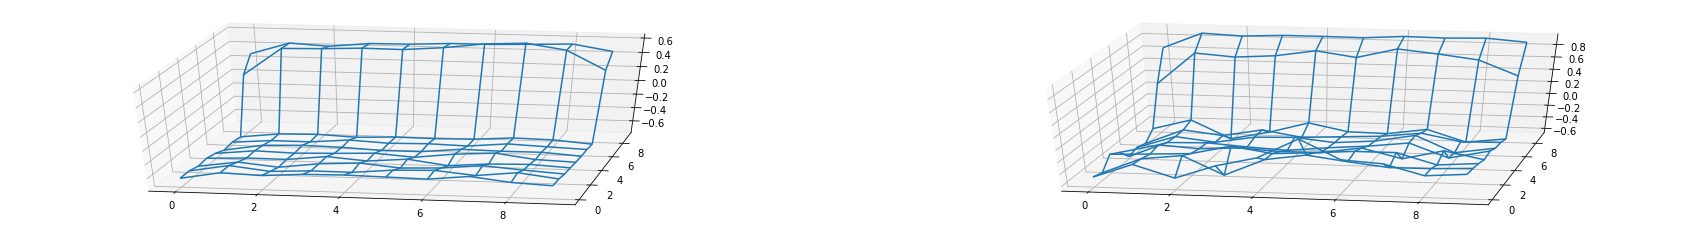

 40%|███▉      | 199088/500000 [00:18<00:23, 12668.84it/s]

Episode: 199999


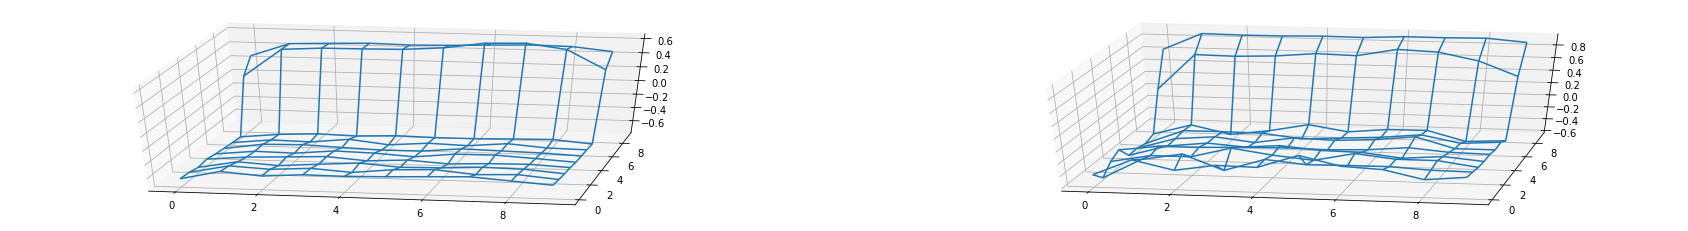

 60%|█████▉    | 299128/500000 [00:26<00:16, 12512.75it/s]

Episode: 299999


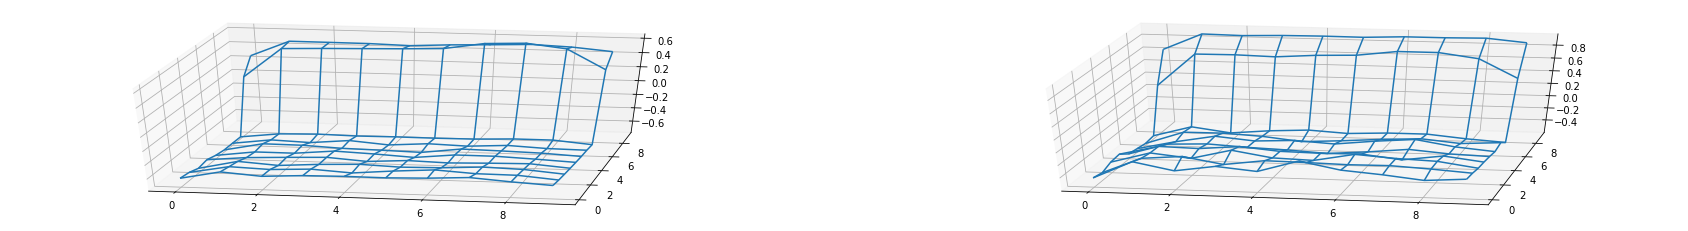

 80%|███████▉  | 399473/500000 [00:40<00:13, 7679.34it/s] 

Episode: 399999


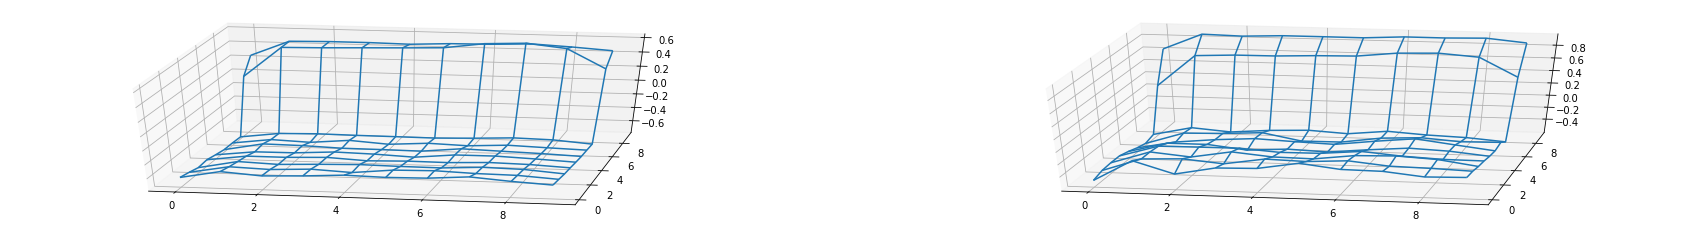

100%|█████████▉| 499291/500000 [00:53<00:00, 8015.38it/s] 

Episode: 499999


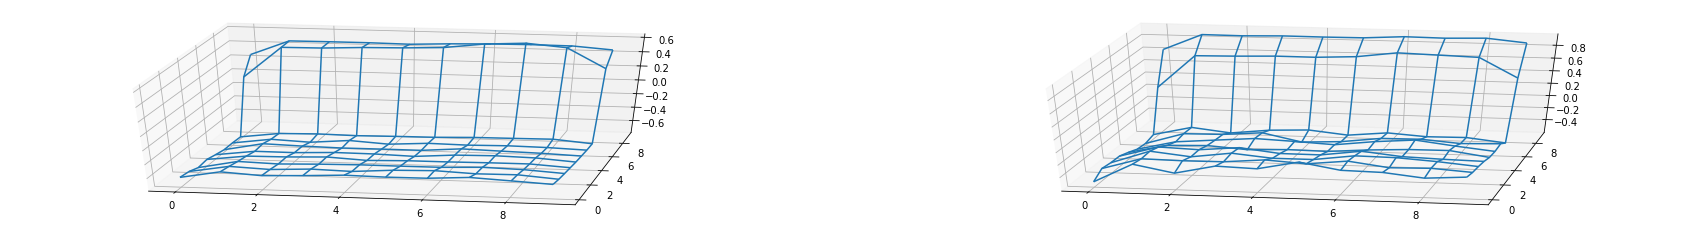

100%|██████████| 500000/500000 [00:53<00:00, 9268.86it/s]


In [5]:
state_value = np.random.random(size=(2, 10, 10))
num_episodes = 500000
gamma = 1.0
all_seen_states = np.zeros(shape=state_value.shape)
for i in tqdm(range(num_episodes)):
    gain = 0
    # Generate an episode w.r.t current policy
    seen_state = np.zeros(shape=state_value.shape)  # 1 if appeared in current episode.
    episode = []
    obs = env.reset()
    while True:
        seen_state[obs] += 1
        act = player_policy(obs[1])
        next_obs, reward, done, _ = env.step(act)
        episode.append((obs, act, reward))
        if done:
            break
        else:
            obs = next_obs

    all_seen_states += (seen_state >= 1).astype('int')  # Since we do a first-visit MC here, just add 1 to all_seen_before
    # Loop for each step of episode from back to front
    gain = 0
    for obs, act, reward in reversed(episode):
        gain = gamma * gain + reward
        if seen_state[obs] > 1:
            seen_state[obs] -= 1
        elif seen_state[obs] == 1:       
            seen_num = all_seen_states[obs]
            old_value = state_value[obs]
            state_value[obs] = (old_value * (seen_num-1) + gain) / seen_num
    if (i+1) % 100000 == 0:
        print("Episode: {}".format(i))
        draw_wireframe(state_value)

### Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$

Basicly the same as GPI (General Policy Iteration), however we don't need to get convergence on each policy evalutation step. Since every step of policy improvement can make the policy better, we can alternate between evaluation and improvement on an episode-by-episode basis.

The policy is improved by:
$$
\pi(S_t) \leftarrow {\arg\max}_a Q(S_t, a)
$$
Thus, we give our policy function an interface to improve it. Also, we compute the average return incrementally here.

In [6]:
class Policy(object):
    def __init__(self):
        self.action_value = np.zeros(shape=(2, 10, 10, 2))  # Last dim is the action dim
        self.pi = np.argmax(self.action_value, axis=-1)
        self.pi[:, :-2, :] = 1
        
    def update(self, obs):
        self.pi[obs] = np.argmax(self.action_value[obs], axis=-1)
                    
    def predict(self, obs):
        assert len(obs) == 3  # 3-dim state tuple
        return int(self.pi[obs])

 20%|█▉        | 198987/1000000 [00:22<01:14, 10807.36it/s]

Episode: 199999


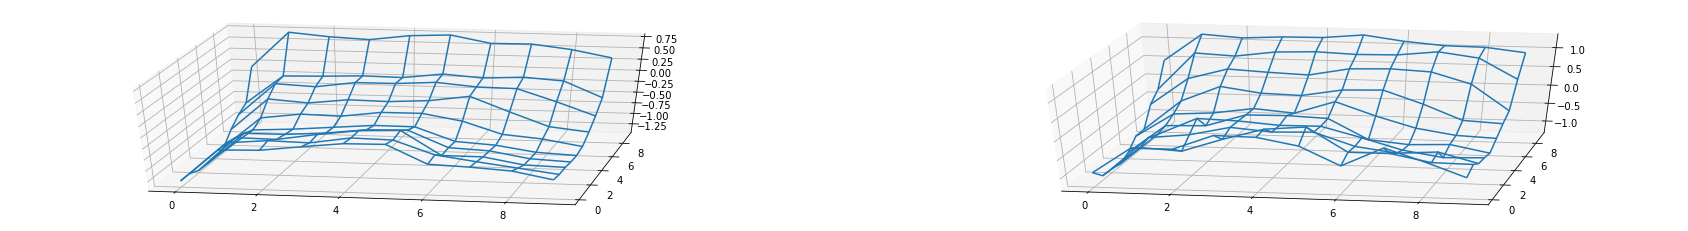

 40%|███▉      | 399452/1000000 [00:43<01:13, 8154.32it/s] 

Episode: 399999


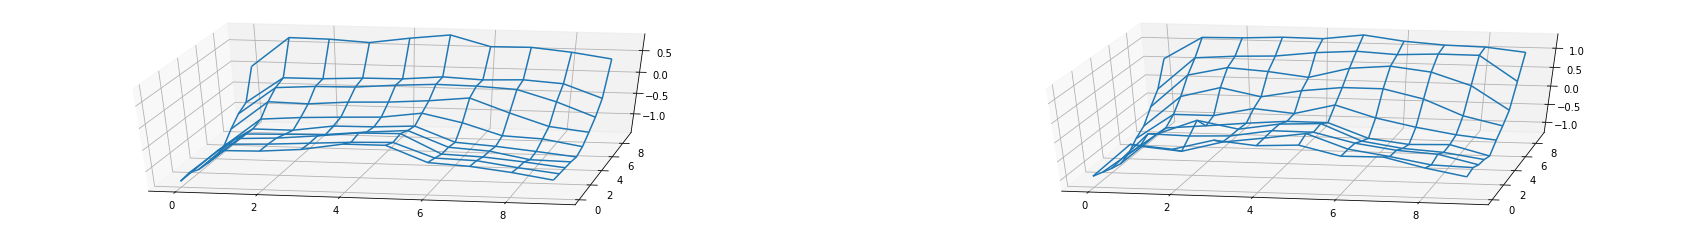

 60%|█████▉    | 598935/1000000 [01:04<00:45, 8744.75it/s] 

Episode: 599999


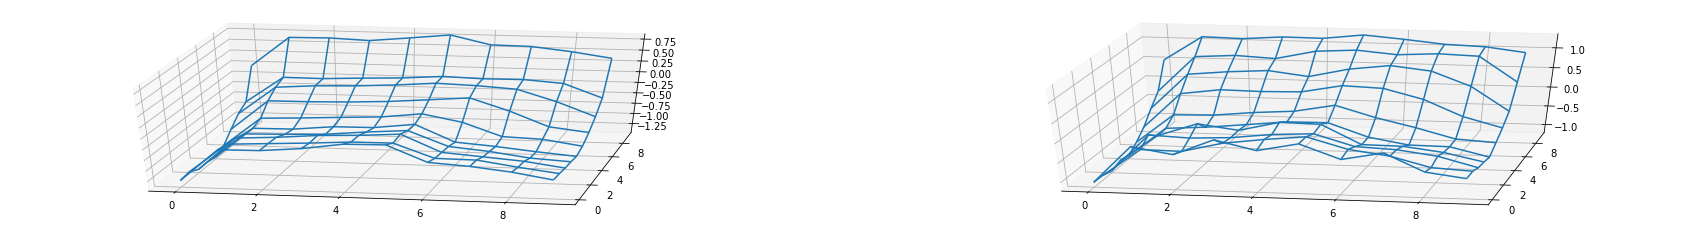

 80%|███████▉  | 798959/1000000 [01:22<00:19, 10567.66it/s]

Episode: 799999


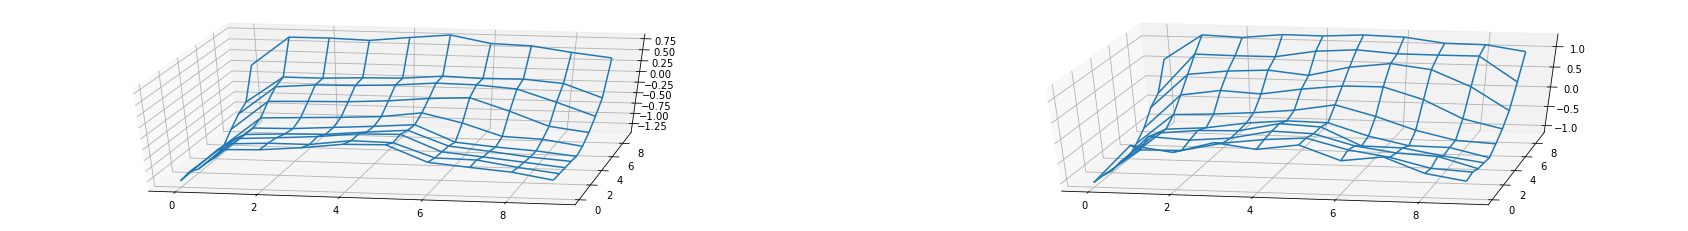

100%|█████████▉| 999886/1000000 [01:41<00:00, 11184.65it/s]

Episode: 999999


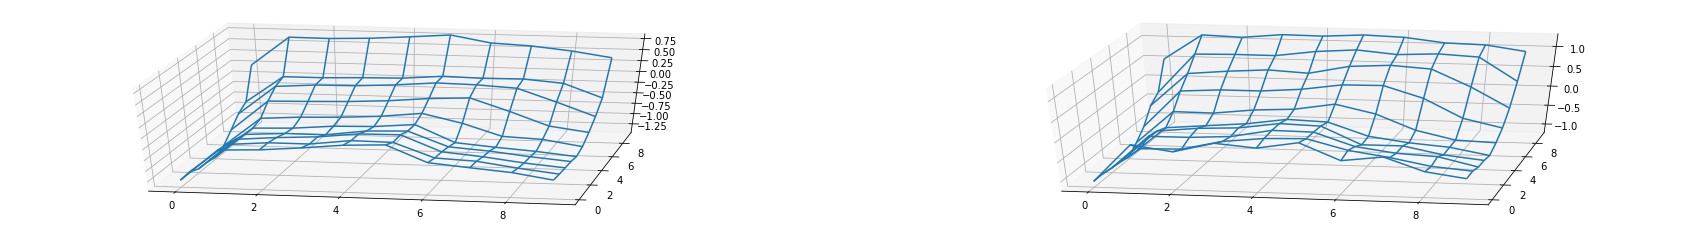

100%|██████████| 1000000/1000000 [01:41<00:00, 9851.97it/s]


In [7]:
# Initialize policy and action-value function
pi = Policy()
num_episodes = 1000000
gamma = 1.0
all_seen_sa_pairs = np.zeros(shape=pi.action_value.shape)
x = 0
total = 0
all_states = set()
for i in tqdm(range(num_episodes)):
    # Generate an episode with exploring start w.r.t. current policy
    seen_sa_pair = np.zeros(shape=pi.action_value.shape)  # Add 1 if appeared in current episode.
    episode = []
    obs = env.reset()
    step = 0
    while True:
        all_states.add(obs)
        if step == 0:
            act = np.random.choice([0, 1])
        else:
            act = pi.predict(obs)
        step += 1
        seen_sa_pair[obs][act] += 1
        next_obs, reward, done, _ = env.step(act)
        episode.append((obs, act, reward))
        if done:
            break
        else:
            obs = next_obs
    all_seen_sa_pairs += (seen_sa_pair >= 1).astype('int')  # Since we do a first-visit MC here, just add 1 to all_seen_before

    # Loop each step of the episode, estimate action-value and improve policy
    gain = 0
    for obs, act, reward in reversed(episode):
        gain = gamma * gain + reward
        usable_ace, player_sum, dealer_deck = obs
        x += usable_ace
        total += 1
        if seen_sa_pair[obs][act] > 1:
            seen_sa_pair[obs][act] -= 1
        elif seen_sa_pair[obs][act] == 1:
            seen_num = all_seen_sa_pairs[obs][act]
            old_value = pi.action_value[obs][act]
            pi.action_value[obs][act] = (old_value * (seen_num - 1) + gain) / seen_num
            pi.update(obs)
    if (i+1) % 200000 == 0:
        print("Episode: {}".format(i))
        draw_wireframe(np.sum(pi.action_value, axis=-1))

### On-policy first-visit MC control (for $\epsilon$-soft policies), estimates $\pi \approx \pi_*$

In [8]:
class SoftPolicy(object):
    def __init__(self, eps=0.1):
        """ This is a binary-action policy, thus `self.prob` is the probability of sampling greedy action (from `self.pi_star`)
        """
        self.action_value = np.zeros(shape=(2, 10, 10, 2))  # Last dim is the action dim
        self.pi_star = np.argmax(self.action_value, axis=-1)
        self.prob = 1 - eps + eps / 2
        
    def update(self, obs):
        self.pi_star[obs] = np.argmax(self.action_value[obs], axis=-1)  # greedy-policy
                    
    def predict(self, obs):
        assert len(obs) == 3  # 3-dim state tuple
        act = int(self.pi_star[obs])
        if np.random.random() >= self.prob:
            act = int(not act)
        return act

 20%|█▉        | 199122/1000000 [00:15<01:02, 12900.29it/s]

Episode: 199999


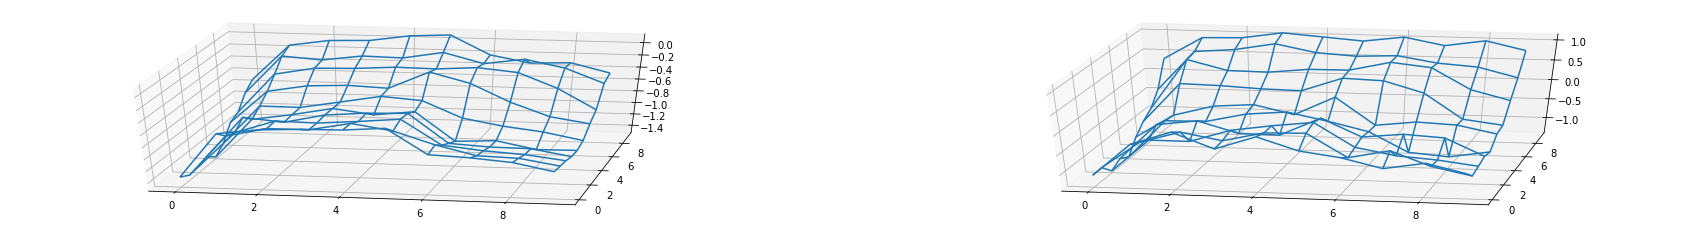

 40%|███▉      | 398907/1000000 [00:32<00:48, 12344.48it/s]

Episode: 399999


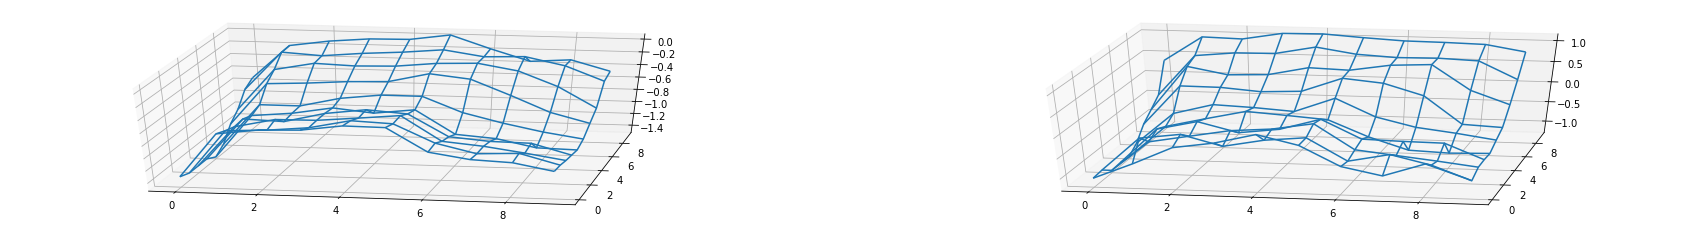

 60%|█████▉    | 599309/1000000 [00:48<00:30, 13099.85it/s]

Episode: 599999


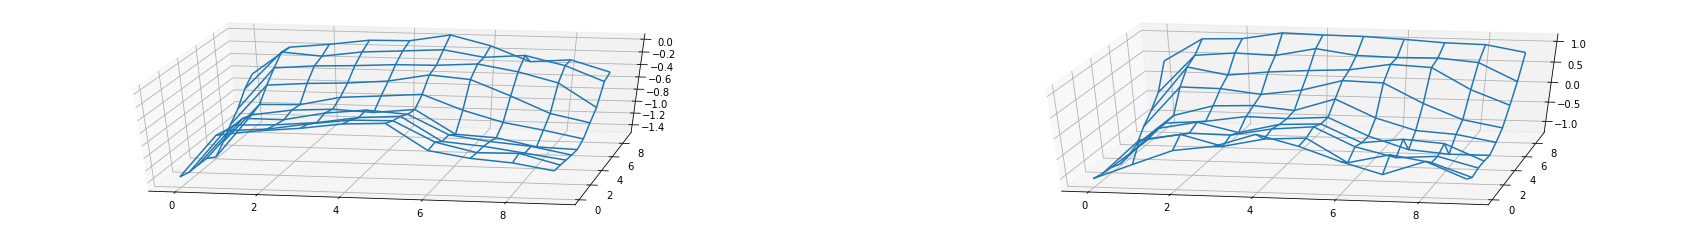

 80%|███████▉  | 799398/1000000 [01:05<00:15, 12887.42it/s]

Episode: 799999


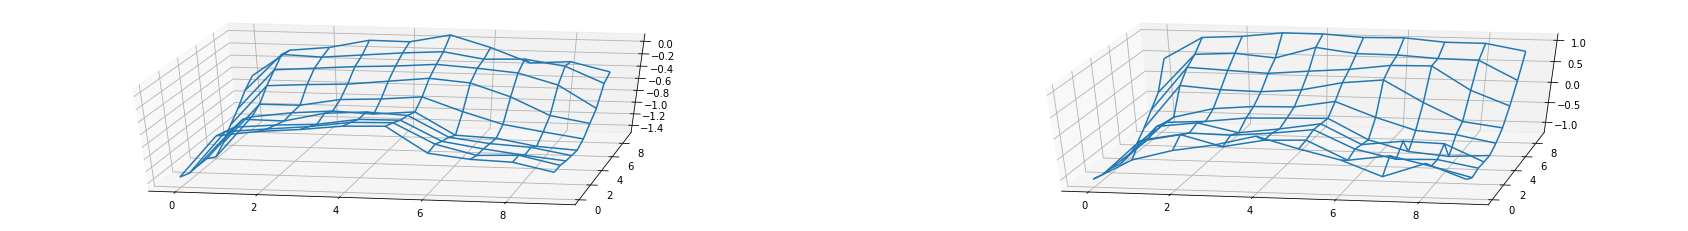

100%|█████████▉| 999664/1000000 [01:21<00:00, 13024.55it/s]

Episode: 999999


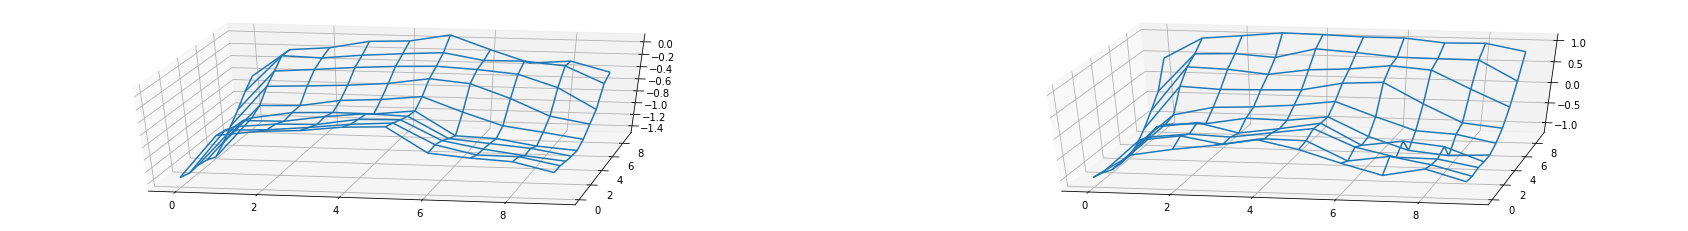

100%|██████████| 1000000/1000000 [01:21<00:00, 12195.28it/s]


In [9]:
# Initialize policy and action-value function
pi = SoftPolicy(eps=0.3)
num_episodes = 1000000
gamma = 1.0
all_seen_sa_pairs = np.zeros(shape=pi.action_value.shape)
x = 0
total = 0
all_states = set()
for i in tqdm(range(num_episodes)):
    # Generate an episode with exploring start w.r.t. current policy
    seen_sa_pair = np.zeros(shape=pi.action_value.shape)  # Add 1 if appeared in current episode.
    episode = []
    obs = env.reset()
    while True:
        all_states.add(obs)
        act = pi.predict(obs)
        seen_sa_pair[obs][act] += 1
        next_obs, reward, done, _ = env.step(act)
        episode.append((obs, act, reward))
        if done:
            break
        else:
            obs = next_obs
    all_seen_sa_pairs += (seen_sa_pair >= 1).astype('int')  # Since we do a first-visit MC here, just add 1 to all_seen_before

    # Loop each step of the episode, estimate action-value and improve policy
    gain = 0
    for obs, act, reward in reversed(episode):
        gain = gamma * gain + reward
        usable_ace, player_sum, dealer_deck = obs
        x += usable_ace
        total += 1
        if seen_sa_pair[obs][act] > 1:
            seen_sa_pair[obs][act] -= 1
        elif seen_sa_pair[obs][act] == 1:
            seen_num = all_seen_sa_pairs[obs][act]
            old_value = pi.action_value[obs][act]
            pi.action_value[obs][act] = (old_value * (seen_num - 1) + gain) / seen_num
            pi.update(obs)
    if (i+1) % 200000 == 0:
        print("Episode: {}".format(i))
        draw_wireframe(np.sum(pi.action_value, axis=-1))